In [1]:
import sys
sys.path.append("../../")

from astronn.preprocess import prebedding
from astronn.datasets import bedding, starmodels
from astronn import models

import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() 

import pandas as pd
import numpy as np
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.mixture import GaussianMixture

from collections import Counter

Using TensorFlow backend.


#### Preprocess is not needed if data exists in beforehand

In [2]:
# Preprocess bedding stars (only once)
if False:
    preprocessor = prebedding(conf_file="../../astronn/data/bedding/parameters.csv", cols=["tess", "dnu"])
    preprocessor.preprocess_files(
        input_folder="../data/bedding/raw/*",
        output_folder="../data/bedding/preprocessed/",
    )

#### Load bedding stars data

In [3]:
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=57)

##### Take and show one example

b'tess2018234235059-s0002-0000000281499618-0121-s_lc_det'
82.98611199414289


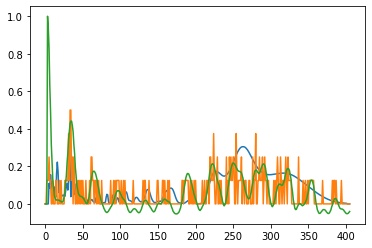

In [4]:
aux = None
for star in df_bedding.take(1):  # take the 1 bedding stars
    aux = star
    print(str(star[0].numpy()[0]))
    print(str(star[3].numpy()[0] / 0.0864)) # Show dnu in muHz from Bedding's paper
x = aux[1].numpy()

plt.plot(x[0, :, 0])
plt.plot(x[0, :, 1])
plt.plot(x[0, :, 2])
plt.show()

#### Utils functions

In [5]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Custom metrics
def top_2_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_4_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=4)

def top_6_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=6)

def top_8_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=8)

def calculate_shap_by_gradient(model, x_explain):
    """
    """
    e = shap.GradientExplainer(model, x_train, batch_size=1000, local_smoothing=0)
    shap_values, indexes = e.shap_values(x_explain, nsamples=10000, ranked_outputs=5)
    return shap_values, indexes

## Bedding 57 stars process

#### Read star models for Shap computation and load saved NN model

In [6]:
# Read datasets of preprocessed stars
bedding_stars = bedding()
df = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150, add_noise=True)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)
number_shap_plots = 1

# Load model
sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400/")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 10)           610       
_________________________________________________________________
batch_normalization (BatchNo (None, 397, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 194, 10)           1510      
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 10)           40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 10)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 47, 10)            1

### NN inference on  bedding stars

In [7]:

# Shap explainer
e = shap.GradientExplainer(sepconv_mod, _train_shap, batch_size=10, local_smoothing=0)
# DS to save results
results = {}
# Loop over stars under study
count = 0
for star in df.take(57):  # take the 57 bedding stars
    if True:
        # Star channels info
        x_star = star[1].numpy()

        # Dnu NN inference
        dnu_hat = sepconv_mod.predict_classes(star[1])

        # Plot graphs and info (debug)
        if True:
            # Calculate gradient explainers and shap values
            shap_values, indexes = e.shap_values(
                star[1].numpy(), nsamples=100, ranked_outputs=40
            )

            # Log info
            print("Count: ", count)
            print("Star ID:", star[0].numpy()[0].decode("utf-8"))
            print("Shap values (sorted):", indexes)

            # Get top-k components
            gmm = GaussianMixture(n_components=3).fit(indexes[0].reshape(-1, 1))
            labels = gmm.predict(indexes[0].reshape(-1, 1))

            def sort_dict(x):
                return {
                    k: v
                    for k, v in sorted(
                        x.items(), key=lambda item: item[1], reverse=True
                    )
                }

            print("Top-k components")
            topk_components = sort_dict(
                dict(zip([e[0] for e in gmm.means_], [e for e in gmm.weights_]))
            )
            print(topk_components)

            # Save results
            if star[0].numpy()[0].decode("utf-8") not in results:
                results[star[0].numpy()[0].decode("utf-8")] = {}
            results[star[0].numpy()[0].decode("utf-8")]["top-1"] = sepconv_mod.predict_classes(star[1])[0]
            results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = list(topk_components)[0]
            results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = list(topk_components)[1]
            results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = list(topk_components)[2]
            results[star[0].numpy()[0].decode("utf-8")]["dnu"] = star[3].numpy()[0] / 0.0864
            results[star[0].numpy()[0].decode("utf-8")]["prob"] =  sepconv_mod.predict_proba(star[1])[0][sepconv_mod.predict_classes(star[1])[0]]

            # Plot star
            if False:
                x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
                plt.plot(x, x_star[0, :, 0])
                plt.plot(x, x_star[0, :, 1])
                plt.plot(x, x_star[0, :, 2])
                plt.show()
                plt.plot(sepconv_mod.predict_proba(x_star)[0][0:100])
                plt.show()

                # Plot shap
                
                plt.plot(
                    x,
                    shap_values[0][0][:, [0]],
                    label="dft",
                    linestyle="solid",
                    color="blue",
                )
                plt.plot(
                    x,
                    shap_values[0][0][:, [1]],
                    label="hd",
                    linestyle="solid",
                    color="orange",
                )
                plt.plot(
                    x,
                    shap_values[0][0][:, [2]],
                    label="ac",
                    linestyle="solid",
                    color="green",
                )

                plt.legend(title="Channels")
                plt.show()
                
                print("\n")

    count += 1


 38 81 82 37 39 83 73 40 41 36 42 53 57 84 52 54 43
  35 55 72 51 85 56 34 44 50 58 33 66 48 62 47 46]]
Top-k components
{78.35600180693969: 0.3537851804254319, 53.88300700243149: 0.33167707436008775, 39.12741739352687: 0.3145377452144804}
Count:  2
Star ID: tess2018319095959-s0005-0000000246902545-0125-s_lc_det
Shap values (sorted): [[34 33 32 31 35 36 30 29 37 22 28 23 20 38 21 19 39 24 27 26 43 40 18 25
  44 41 69 42 70 46 66 71 68 67 45 47 72 16 17 49]]
Top-k components
{24.252185132945872: 0.42323150901858364, 40.22396175348572: 0.4017688485270029, 69.0000055025173: 0.17499964245441363}
Count:  3
Star ID: tess2018234235059-s0002-0000000281499618-0121-s_lc_det
Shap values (sorted): [[21 22 20 24 29 23 26 25 28 27 34 32 35 18 30 31 19 39 37 40 38 33 51 54
  36 41 53 50 55 79 47 49 43 46 52 44 42 48 62 56]]
Top-k components
{48.067045130582706: 0.4523974393964988, 36.938173471731574: 0.28553606596159226, 23.59100172302102: 0.26206649464190906}
Count:  4
Star ID: tess2018319095959-s00

### Histogram of results for all stars (top-1)

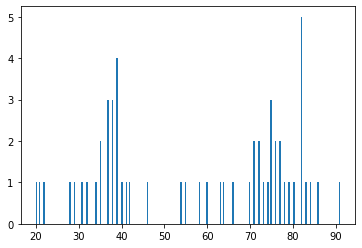

In [8]:
plt.hist([results[r]["top-1"] for r in results], bins=200)
plt.show()

In [9]:
df = pd.DataFrame.from_dict(results, orient="index")
df

,top-1,top-k1,top-k2,top-k3,dnu,prob
tess2018349182459-s0006-0000000034737955-0126-s_lc_det,64,88.297577,65.432926,44.499991,69.791669,0.136931
tess2018349182459-s0006-0000000294157254-0126-s_lc_det,76,78.356002,53.883007,39.127417,80.092593,0.240811
tess2018319095959-s0005-0000000246902545-0125-s_lc_det,34,24.252185,40.223962,69.000006,70.601851,0.398031
tess2018234235059-s0002-0000000281499618-0121-s_lc_det,21,48.067045,36.938173,23.591002,82.986112,0.304529
tess2018319095959-s0005-0000000459942890-0125-s_lc_det,39,77.810929,41.412322,55.217154,82.870369,0.237194
tess2018349182459-s0006-0000000148228220-0126-s_lc_det,82,76.556624,46.520277,59.726246,83.912037,0.154898
tess2019006130736-s0007-0000000284348793-0131-s_lc_det,75,78.009391,58.216690,35.999463,81.944444,0.452991
tess2018349182459-s0006-0000000011199304-0126-s_lc_det,32,62.716757,28.696812,45.139491,68.981482,0.365773
tess2018234235059-s0002-0000000327996759-0121-s_lc_det,91,89.874213,66.734257,44.488463,69.907407,0.271181
tess2018349182459-s0006-0000000037498433-0126-s_lc_det,28,40.114519,23.779128,67.696527,82.175925,0.223746


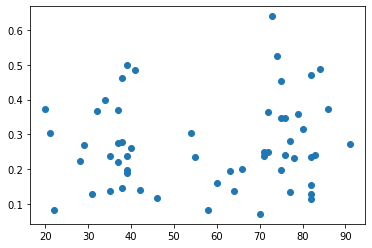

In [10]:
plt.scatter(df["top-1"], df["prob"])

In [11]:
inferences = [results[r]["top-1"] for r in results]
targets = [results[r]["dnu"] for r in results]
ids = results.keys()

Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

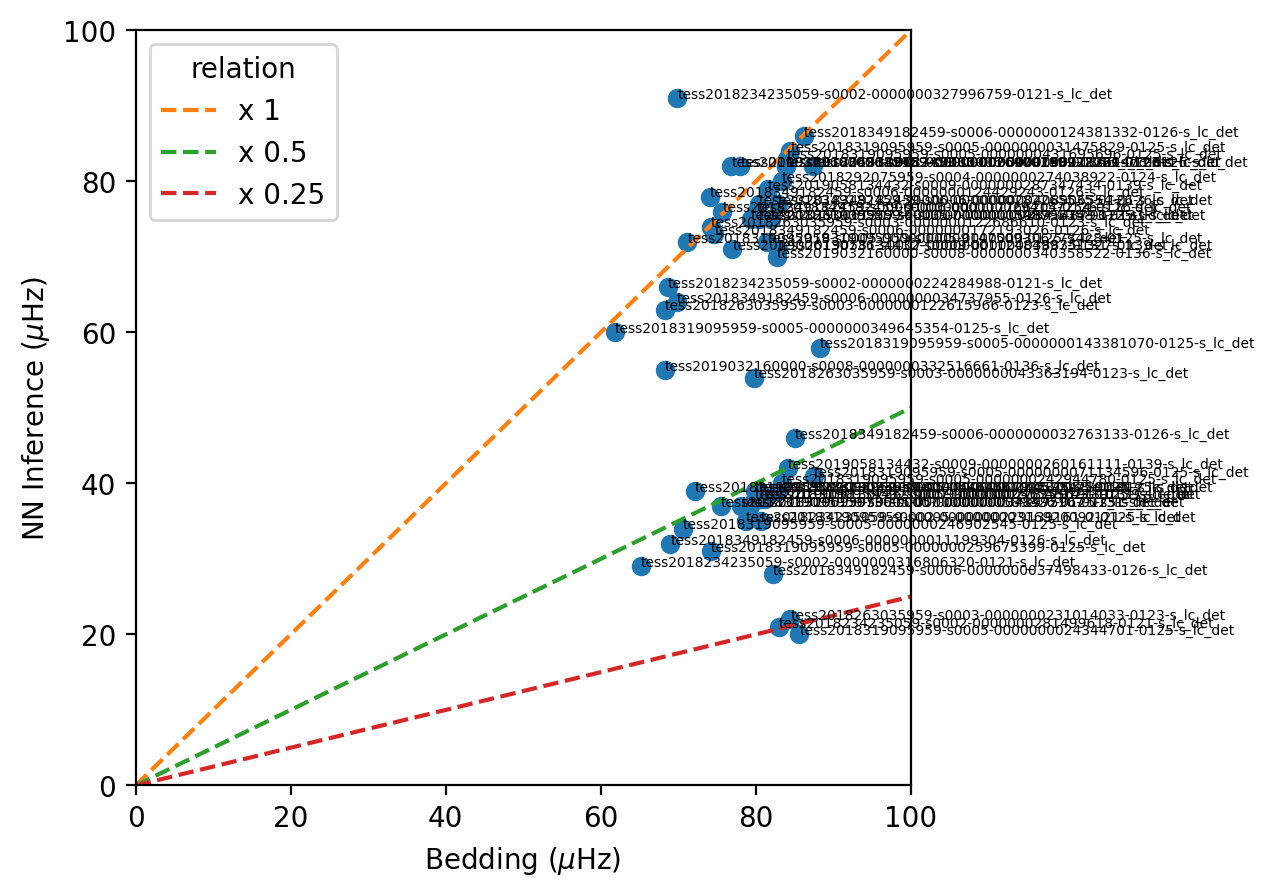

In [12]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label="x "+str(slope))
    
# Set lims
plt.subplots(1, figsize=(5, 5), dpi=200)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.plot(targets, inferences, "o") # Plot relation
for i, txt in enumerate(ids):
    plt.annotate(txt, (targets[i], inferences[i]), size=5)

# Add multiple and submultiples
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

In [13]:
df.to_csv("/tmp/bedding_nn.csv.gz", index=True)

In [14]:
import numpy as np
len([e for e in np.unique([ee.split("-")[2] for ee in pd.read_csv('/tmp/bedding_nn.csv.gz', compression='gzip', header=0)["Unnamed: 0"]])])

57

In [15]:
np.unique([e.split("-")[0] for e in df.index])
len(df)

57

In [16]:
df["TIC"] = (
    df.index.str.split("-", n=2, expand=False)
    .str[2]
    .str.split("-")
    .str[0]
    .astype(int)
    .astype(str)
)
df_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
df_joined = df.set_index("TIC").join(df_att.set_index("TIC"))
# Add flag
df_joined["abs_error"] = np.abs(df_joined["top-1"] - df_joined["dnu"])
df_joined["flag"] = df_joined["abs_error"] < 12
pd.set_option("display.max_columns", None)
df_joined

,top-1,top-k1,top-k2,top-k3,dnu,prob,HD,Name,V,Teff,L,e.L.,rho,e.rho.,Dnu,eps,vsini,e.vsini.,F0,abs_error,flag
TIC,,,,,,,,,,,,,,,,,,,,,
34737955,64,88.297577,65.432926,44.499991,69.791669,0.136931,44930.0,NaN,9.42,7320.0,7.17,0.40,0.33,0.05,6.03,1.67,NaN,NaN,16.1001,5.791669,True
294157254,76,78.356002,53.883007,39.127417,80.092593,0.240811,55863.0,NaN,9.06,7650.0,7.80,0.38,0.38,0.05,6.92,1.57,99.0,5.0,17.7844,4.092593,True
246902545,34,24.252185,40.223962,69.000006,70.601851,0.398031,31322.0,NaN,9.28,8260.0,13.19,0.67,0.32,0.04,6.10,1.69,200.0,50.0,16.4090,36.601851,False
281499618,21,48.067045,36.938173,23.591002,82.986112,0.304529,2280.0,NaN,9.13,7510.0,5.52,0.26,0.49,0.06,7.17,1.73,26.4,1.3,19.5741,61.986112,False
459942890,39,77.810929,41.412322,55.217154,82.870369,0.237194,25248.0,NaN,8.60,NaN,NaN,NaN,NaN,NaN,7.16,1.55,NaN,NaN,18.2580,43.870369,False
148228220,82,76.556624,46.520277,59.726246,83.912037,0.154898,48985.0,NaN,9.04,7710.0,11.60,0.54,0.25,0.03,7.25,1.56,40.0,4.0,18.5600,1.912037,True
284348793,75,78.009391,58.216690,35.999463,81.944444,0.452991,54711.0,NaN,9.01,8200.0,9.22,0.45,0.44,0.06,7.08,1.65,50.0,2.0,18.7620,6.944444,True
11199304,32,62.716757,28.696812,45.139491,68.981482,0.365773,290750.0,NaN,9.77,9170.0,19.14,1.13,0.35,0.05,5.96,NaN,NaN,NaN,NaN,36.981482,False
327996759,91,89.874213,66.734257,44.488463,69.907407,0.271181,220811.0,NaN,6.91,NaN,NaN,NaN,NaN,NaN,6.04,1.82,261.0,40.0,17.0328,21.092593,False


### Multilevel analisis

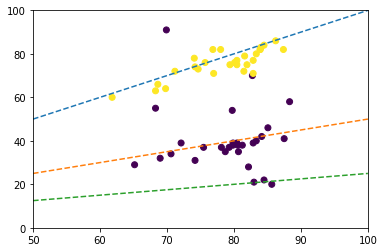

In [17]:
#df_joined = df_joined.drop("143381070")
#df_joined = df_joined.drop("332516661")
#df_joined = df_joined.drop("327996759")
#df_joined = df_joined.drop("43363194")
plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["flag"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       8.132
Link Function:                        LogitLink Log Likelihood:                                   -28.8776
Number of Samples:                           46 AIC:                                               74.0193
                                                AICc:                                              79.1785
                                                UBRE:                                               3.7505
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0943
Feature Function                  Lam

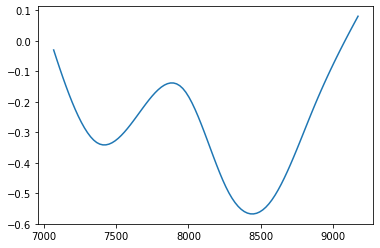

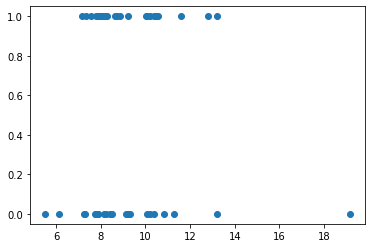

In [18]:
from pygam import LogisticGAM, LinearGAM, s, te
_x = df_joined[
    df_joined["L"].notna() & df_joined["Teff"].notna() & df_joined["V"].notna()
]
gam = LogisticGAM(s(0) + s(1) + s(2), n_splines=10)
gam.fit(_x[["L", "Teff", "V"]], _x["flag"])
gam.summary()

XX = gam.generate_X_grid(term=1)
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX))
plt.show()
plt.scatter(_x["L"], _x["flag"])

_x.to_csv("/home/roberto/bedding_joined.csv", index=True)

## Join Star models with ${\Delta\nu}_{bedding}$ and ${T_{eff}}_{bedding}$  

In [19]:
df_dnus = pd.read_csv("/tmp/files_dnus.csv",sep=",",header=0,  names=["file", "dnu"])
df_dnus.head()

,file,dnu
0,VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a16...,5.118
1,VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a...,4.787
2,VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a16...,3.416
3,VO-m145fe-3a164o0rotjpzt5p5-ad/00960-m145fe-3a...,5.022
4,VO-m135fe010a164o00rotjpzt5p7-ad/00292-m135fe0...,7.687


In [20]:
with open(
    "/home/roberto/Projects/asteroseismologyNN/selected_models_preprocessed.csv", "w"
) as outfile:
    wr = csv.writer(outfile)
    wr.writerow(["xc", "l", "teff", "selected", "path"])
    with open(
        "/home/roberto/Projects/asteroseismologyNN/selected_models.csv", "r"
    ) as infile:
        for id, row in enumerate(infile):
            if id > 0:
                chunks = row.split(",")
                if len(chunks) == 8:
                    try:
                        aux = [
                            float(chunks[0] + "." + chunks[1]),
                            float(chunks[2] + "." + chunks[3]),
                            float(chunks[4] + "." + chunks[5]),
                            chunks[6],
                            chunks[7].replace('"', "").replace("\n", ""),
                        ]
                        wr.writerow(aux)
                    except:
                        aux = [
                            float(0.0),
                            float(0.0),
                            float(chunks[4] + "." + chunks[5]),
                            chunks[6],
                            chunks[7].replace('"', "").replace("\n", ""),
                        ]
                        wr.writerow(aux)

In [21]:
df_l_teff = pd.read_csv(
    "/home/roberto/Projects/asteroseismologyNN/selected_models_preprocessed.csv",
    sep=",",
    header=0,
    names=["xc", "l", "teff", "selected", "path"],
)
df_l_teff.head()
print(len(df_l_teff))

506784


In [22]:
df_dnu_l_teff = df_dnus.set_index("file").join(df_l_teff.set_index("path"))
df_dnu_l_teff["dnu"] = df_dnu_l_teff["dnu"] / 0.0864
df_dnu_l_teff.head()

,dnu,xc,l,teff,selected
file,,,,,
VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a164o0rotjpzt5p7-ad.frq,59.236111,0.622402,52.276290,10643.345609,True
VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a164o0rotjpzt5p7-ad.frq,55.405093,0.631469,36.650261,9763.029945,True
VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a164o0rotjpzt5p7-ad.frq,39.537037,0.372260,63.041466,9777.683034,True
VO-m145fe-3a164o0rotjpzt5p5-ad/00960-m145fe-3a164o0rotjpzt5p5-ad.frq,58.125000,0.138201,4.259204,5961.591979,True
VO-m135fe010a164o00rotjpzt5p7-ad/00292-m135fe010a164o00rotjpzt5p7-ad.frq,88.969907,0.514600,3.247009,6456.429298,True


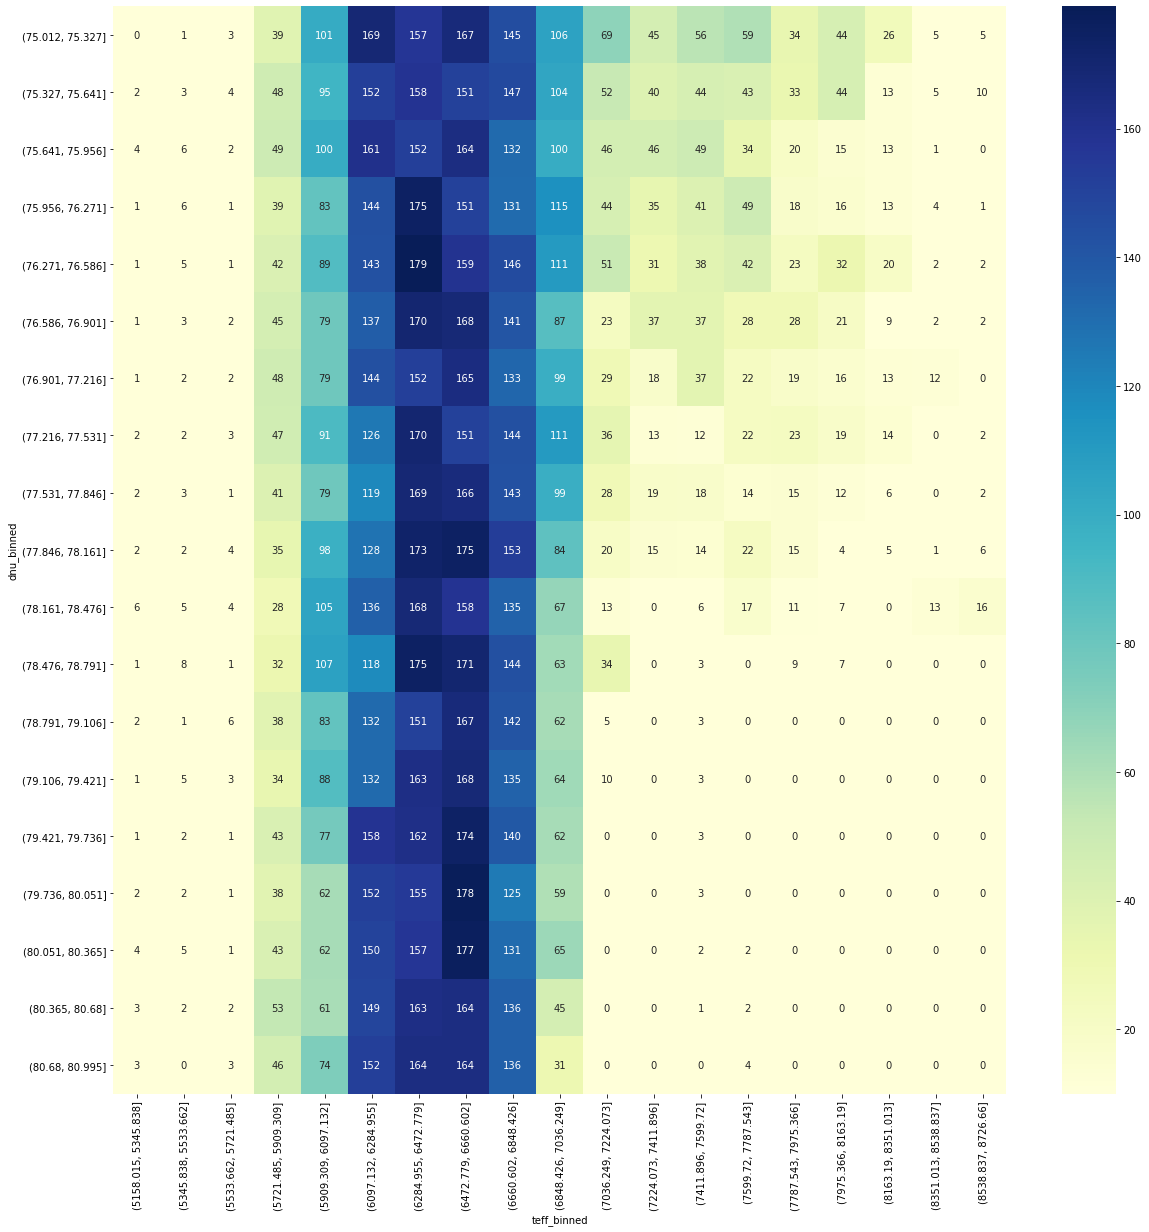

In [23]:
df_dnu_l_teff_filter = df_dnu_l_teff[
    (df_dnu_l_teff["dnu"] < 81) & (df_dnu_l_teff["dnu"] > 75)
]

df_dnu_l_teff_filter["dnu_binned"] = pd.cut(
    df_dnu_l_teff_filter["dnu"],
    np.linspace(
        df_dnu_l_teff_filter["dnu"].min(), df_dnu_l_teff_filter["dnu"].max(), 20
    ),
)
df_dnu_l_teff_filter["teff_binned"] = pd.cut(
    df_dnu_l_teff_filter["teff"],
    np.linspace(
        df_dnu_l_teff_filter["teff"].min(), df_dnu_l_teff_filter["teff"].max(), 20
    ),
)

df_grouped = (
    df_dnu_l_teff_filter.groupby(["dnu_binned", "teff_binned"]).size().unstack()
)
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(df_grouped, linewidth=0.0, annot=True, cmap="YlGnBu", fmt="d", vmin=10)
plt.show()

## Inclination angle

In [30]:
results = []
for index in range(len(df_joined)):
    flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-1"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-1"] + 1.0
    )
    flag_teff = (
        df_dnu_l_teff["teff"]
        >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.02
    ) & (
        df_dnu_l_teff["teff"]
        <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.02
    )
    selected = df_dnu_l_teff[flag_dnu & flag_teff]["l"]
    if np.isnan(selected.mean()):
        results.append(np.nan)
    else:
        results.append(df_joined.iloc[index]["L"] > selected.quantile(0.1))

df_joined["inc_angle"] = results
df_joined.head(30)[["top-1", "L", "dnu", "inc_angle"]]
print(df_joined[["Teff", "L", "top-1", "dnu", "inc_angle", "flag"]].head(50))

results = []
inferences = []
for index in range(len(df_joined)):
    subresult = []
    for inference in ["top-1", "top-k1", "top-k2", "top-k3"]:
        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index][inference] - 1.0) & (
            df_dnu_l_teff["dnu"] <= df_joined.iloc[index][inference] + 1.0
        )
        flag_teff = (
            df_dnu_l_teff["teff"]
            >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.1
        ) & (
            df_dnu_l_teff["teff"]
            <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.1
        )
        selected = df_dnu_l_teff[flag_dnu & flag_teff]["l"]
        if np.isnan(selected.mean()):
            subresult.append(np.nan)
        else:
            subresult.append(round(abs(df_joined.iloc[index]["L"]-selected.quantile(0.5)), 2))
    
    subresult.append(df_joined.iloc[index]["L"])
    results.append(subresult)

             Teff      L  top-1        dnu inc_angle   flag
TIC                                                        
34737955   7320.0   7.17     64  69.791669      True   True
294157254  7650.0   7.80     76  80.092593      True   True
246902545  8260.0  13.19     34  70.601851     False  False
281499618  7510.0   5.52     21  82.986112     False  False
459942890     NaN    NaN     39  82.870369       NaN  False
148228220  7710.0  11.60     82  83.912037     False   True
284348793  8200.0   9.22     75  81.944444     False   True
11199304   9170.0  19.14     32  68.981482     False  False
327996759     NaN    NaN     91  69.907407       NaN  False
37498433   8170.0  10.05     28  82.175925     False  False
408906554  8030.0   8.75     77  82.870369      True   True
172193026  7810.0   8.28     73  74.652776      True   True
306773428     NaN    NaN     72  81.481481       NaN   True
269792989     NaN    NaN     82  78.009257       NaN   True
340358522  7490.0   7.30     70  82.7546

In [31]:
m = pd.DataFrame(np.asarray(results))
m.index = df_joined.index
m

,0,1,2,3,4
TIC,,,,,
34737955,0.23,3.37,0.06,6.91,7.17
294157254,1.13,2.72,4.69,13.25,7.80
246902545,21.32,35.94,13.97,2.54,13.19
281499618,35.50,7.35,13.19,25.23,5.52
459942890,NaN,NaN,NaN,NaN,NaN
148228220,1.69,4.80,3.35,1.24,11.60
284348793,0.54,0.67,4.97,21.45,9.22
11199304,40.52,1.95,44.39,20.85,19.14
327996759,NaN,NaN,NaN,NaN,NaN


In [32]:
def f(row):
    if np.isnan(row["inc_angle"]):
        val = 0
    else:
        val = 1
    return val
df_joined['drop'] = df_joined.apply(f, axis=1)

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.6986
Link Function:                     IdentityLink Log Likelihood:                                  -159.5785
Number of Samples:                           47 AIC:                                              328.5541
                                                AICc:                                             329.8507
                                                GCV:                                                0.1111
                                                Scale:                                              0.0955
                                                Pseudo R-Squared:                                   0.2102
Feature Function                  Lam

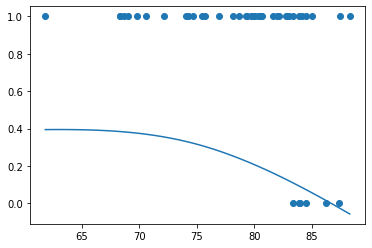

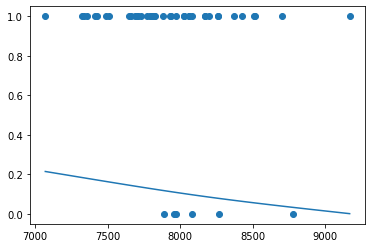

In [33]:
_x = df_joined[df_joined['Teff'].notna()]

gam = LinearGAM(s(0)+s(1), n_splines=5)
gam.fit(_x[["dnu","Teff"]], _x["drop"])
gam.summary()

XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
plt.scatter(_x["dnu"], _x["drop"])
plt.show()

XX = gam.generate_X_grid(term=1)
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX))
plt.scatter(_x["Teff"], _x["drop"])

In [34]:
df_joined.groupby(["flag", "inc_angle"]).size().unstack(fill_value=0)

inc_angle,False,True
flag,,
False,23,1
True,7,10


Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

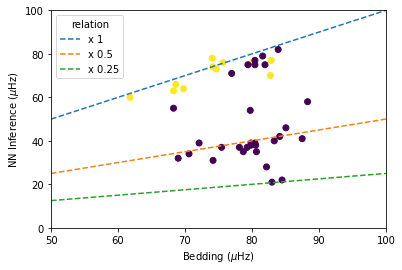

In [35]:
plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["inc_angle"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -19.3783
Number of Samples:                           40 AIC:                                               42.7565
                                                AICc:                                              43.4232
                                                UBRE:                                               3.1089
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2895
Feature Function                  Lam

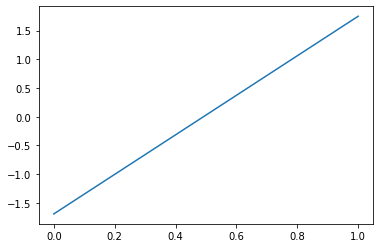

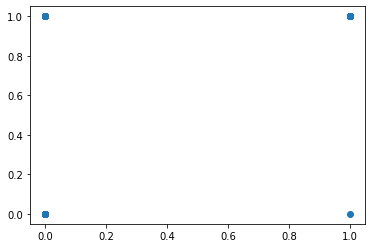

In [36]:
_x = df_joined[df_joined["inc_angle"].notna() & df_joined["L"].notna()]
gam = LogisticGAM(s(0))
gam.fit(_x[["inc_angle"]], _x["flag"])
gam.summary()

XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
plt.show()
plt.scatter(_x["inc_angle"], _x["flag"])

_x.to_csv("/home/roberto/bedding_joined.csv", index=True)

## $T_{eff}$, L and $\Delta \nu$ star models match

In [37]:
results = []
for index in range(len(df_joined)):
    flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-1"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-1"] + 1.0
    )
    flag_teff = (
        df_dnu_l_teff["teff"]
        >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.02
    ) & (
        df_dnu_l_teff["teff"]
        <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.02
    )
    flag_l = (df_dnu_l_teff["l"] >= df_joined.iloc[index]["L"] - 3.0) & (
        df_dnu_l_teff["l"] <= df_joined.iloc[index]["L"] + 3.0
    )
    selected = df_dnu_l_teff[flag_dnu & flag_teff & flag_l]
    if np.isnan(df_joined.iloc[index]["L"]):
        results.append(np.nan)
    else:
        results.append(len(selected) > 0)

df_joined["star_match"] = results
print(
    df_joined[["Teff", "L", "top-1", "dnu", "inc_angle", "flag", "star_match"]].head(50)
)

             Teff      L  top-1        dnu inc_angle   flag star_match
TIC                                                                   
34737955   7320.0   7.17     64  69.791669      True   True       True
294157254  7650.0   7.80     76  80.092593      True   True       True
246902545  8260.0  13.19     34  70.601851     False  False      False
281499618  7510.0   5.52     21  82.986112     False  False      False
459942890     NaN    NaN     39  82.870369       NaN  False        NaN
148228220  7710.0  11.60     82  83.912037     False   True       True
284348793  8200.0   9.22     75  81.944444     False   True       True
11199304   9170.0  19.14     32  68.981482     False  False      False
327996759     NaN    NaN     91  69.907407       NaN  False        NaN
37498433   8170.0  10.05     28  82.175925     False  False      False
408906554  8030.0   8.75     77  82.870369      True   True       True
172193026  7810.0   8.28     73  74.652776      True   True       True
306773

star_match  False  True 
flag                    
False          21      2
True            6     17


Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

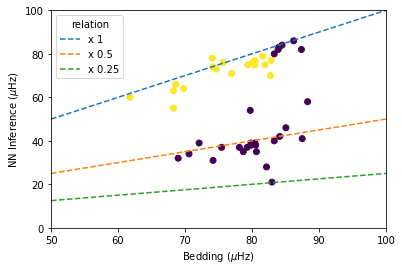

In [38]:
print(df_joined.groupby(["flag", "star_match"]).size().unstack(fill_value=0))

plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["star_match"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

## Get L from adjusted GAM model

In [39]:
df_grouped.head(30).stack()[:3]

dnu_binned        teff_binned         
(75.012, 75.327]  (5158.015, 5345.838]    0
                  (5345.838, 5533.662]    1
                  (5533.662, 5721.485]    3
dtype: int64

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     37.5848
Link Function:                     IdentityLink Log Likelihood:                                -32280.8154
Number of Samples:                        17909 AIC:                                            64638.8004
                                                AICc:                                           64638.9714
                                                GCV:                                                 0.201
                                                Scale:                                              0.2002
                                                Pseudo R-Squared:                                   0.9245
Feature Function                  Lam

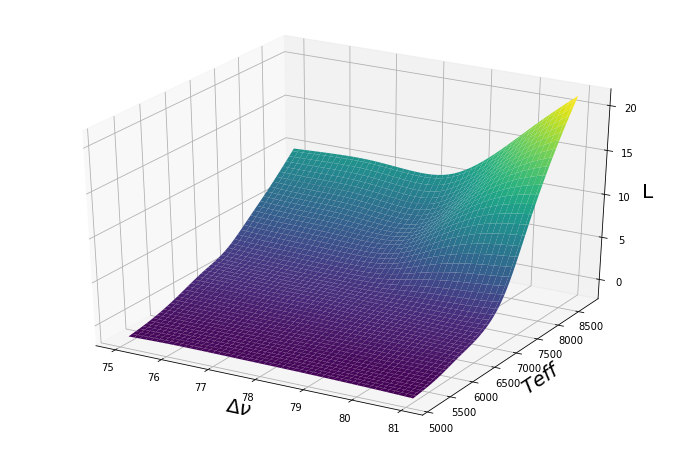

In [40]:
_x = df_dnu_l_teff_filter[df_dnu_l_teff_filter['l'].notna()]

gam = LinearGAM(te(0,1, n_splines=10))
gam.fit(_x[["dnu","teff"]], _x["l"])
gam.summary()

#XX = gam.generate_X_grid(term=0)
#plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
#plt.scatter(_x["teff"], _x["l"])
#plt.show()

XX = gam.generate_X_grid(term=0, meshgrid=True)
Z = gam.partial_dependence(term=0, X=XX, meshgrid=True)

plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)
ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z++ np.mean(gam.predict(_x[["dnu","teff"]])), cmap='viridis')
ax.set_xlabel('$\Delta\\nu$', fontsize=20)
ax.set_ylabel('$Teff$', fontsize=20)
ax.set_zlabel('L', fontsize=20)
plt.show()

In [41]:
_x.loc[_x['l'] > 14]

,dnu,xc,l,teff,selected,dnu_binned,teff_binned
file,,,,,,,
VO-m200fe0a164o0rotjpzt5p7-ad/00051-m200fe0a164o0rotjpzt5p7-ad.frq,75.439815,0.706825,14.113756,8664.280714,True,"(75.327, 75.641]","(8538.837, 8726.66]"


In [42]:
tops = []
for index in range(len(df_joined)):
    subtops = []
    subtops.append(df_joined.iloc[index]["top-1"])
    subtops.append(df_joined.iloc[index]["top-k1"])
    subtops.append(df_joined.iloc[index]["top-k2"])
    subtops.append(df_joined.iloc[index]["top-k3"])
    tops.append(subtops)
tops = pd.DataFrame(np.asarray(tops))
tops

,0,1,2,3
0,64.0,88.297577,65.432926,44.499991
1,76.0,78.356002,53.883007,39.127417
2,34.0,24.252185,40.223962,69.000006
3,21.0,48.067045,36.938173,23.591002
4,39.0,77.810929,41.412322,55.217154
5,82.0,76.556624,46.520277,59.726246
6,75.0,78.009391,58.216690,35.999463
7,32.0,62.716757,28.696812,45.139491
8,91.0,89.874213,66.734257,44.488463
9,28.0,40.114519,23.779128,67.696527


In [51]:
corrected = []
for index in range(len(df_joined)):
    # print(df_joined.iloc[index][["dnu", "Teff", "L", "top-1", "top-k1", "top-k2", "top-k3"]])
    l = df_joined.iloc[index][["L"]][0]

    if not np.isnan(l):
        l_top1 = round(
            gam.predict(
                df_joined.iloc[index][["top-1", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        l_topk1 = round(
            gam.predict(
                df_joined.iloc[index][["top-k1", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        l_topk2 = round(
            gam.predict(
                df_joined.iloc[index][["top-k2", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        l_topk3 = round(
            gam.predict(
                df_joined.iloc[index][["top-k3", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )

        errors = [
            round(np.power(l_top1 - l, 2), 2),
            round(np.power(l_topk1 - l, 2), 2),
            round(np.power(l_topk2 - l, 2), 2),
            round(np.power(l_topk3 - l, 2), 2),
        ]
        # print(errors)
        corrected.append(tops.iloc[index][errors.index(min(errors))])
    else:
        corrected.append(np.nan)


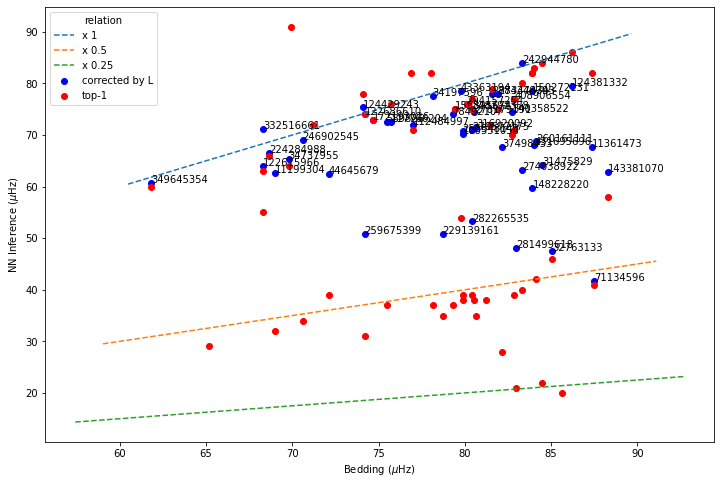

In [52]:
df_joined["corrected"] = corrected
fig, ax = plt.subplots()
ax.scatter(df_joined["dnu"], df_joined["corrected"], c="blue", label="corrected by L")
ax.scatter(df_joined["dnu"], df_joined["top-1"], c="red", label="top-1")
n = df_joined.index

for i, txt in enumerate(n):
    ax.annotate(txt, (df_joined.iloc[i][["dnu"]], df_joined.iloc[i][["corrected"]]))

abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")
plt.show()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.1303
Link Function:                     IdentityLink Log Likelihood:                                  -204.6851
Number of Samples:                           46 AIC:                                              427.6309
                                                AICc:                                              432.788
                                                GCV:                                               49.0385
                                                Scale:                                              33.735
                                                Pseudo R-Squared:                                   0.2134
Feature Function                  Lam

[<matplotlib.lines.Line2D at 0x7f3a07118890>]

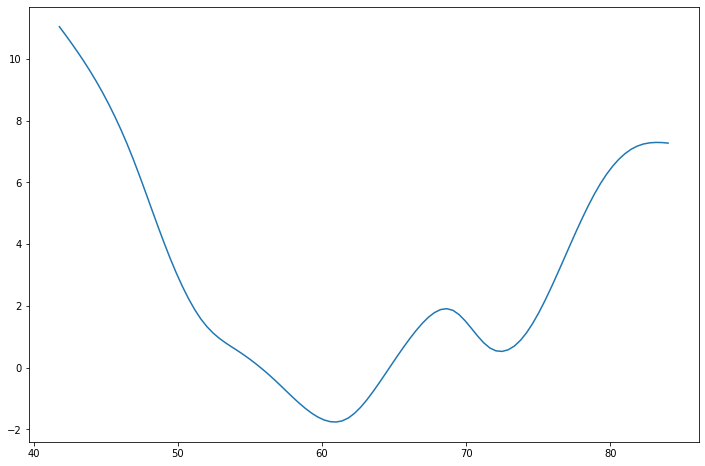

In [53]:
_x = df_joined[df_joined['corrected'].notna()]

gam2 = LinearGAM(s(0, n_splines=20))
gam2.fit(_x[["corrected"]], _x["dnu"])
gam2.summary()

XX = gam2.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam2.partial_dependence(term=0, X=XX))